# Manual KPI Analysis

Load KPI data from CSV for manual exploration.

In [1]:
from pathlib import Path


import matplotlib.pyplot as plt


import pandas as pd

In [2]:
# Try common relative locations so the notebook works from repo root or analysis folder.
from copy import copy


potential_paths = [
    Path("analysis") / "tables" / "kpis.csv",
    Path("tables") / "kpis.csv",
    Path("..") / "analysis" / "tables" / "kpis.csv",
]
for candidate in potential_paths:
    if candidate.exists():
        csv_path = candidate.resolve()
        break
else:
    raise FileNotFoundError("Could not locate analysis/tables/kpis.csv from current working directory.")
df_raw = pd.read_csv(csv_path)



In [3]:
df = copy(df_raw)


# Make 'confid_id' row be the header 
df.columns = df.iloc[0]
df = df[1:]


# Rename columns. dial-efficiency -> E, dials-balanced -> B, dials-fairness -> F, dials-adequacy -> A, dials-fairness-adequacy -> FA
df = df.rename(columns={
    "config_id": "KPI",
    "dials-efficiency": "E",
    "dials-balanced": "B",
    "dials-fairness": "F",
    "dials-adequacy": "A",
    "dials-fairness-adequacy": "FA"
})


# Make 'config_id' be the index
df = df.set_index("KPI")


# Remove row 'kpi'
df = df[df.index != "kpi"]


# Convert KPI values to numeric so plotting uses continuous axes
df = df.apply(pd.to_numeric, errors="coerce")


# Name header (column names) as 'Dials Config'
df.columns.name = "Dials Config"


df.round(2)

Dials Config,E,F,A
KPI,,,
Items,4.00,4.00,4.00
Households,3.00,3.00,3.00
Nutrients,3.00,3.00,3.00
Objective value,6.74,5.88,3.64
Total allocation,61.00,56.00,60.00
Avg allocation per pair,20.33,18.67,20.00
Undistributed,0.00,0.00,1.00
Total cost,10.00,7.10,9.90
Total nutritional utility,6.74,5.88,3.64


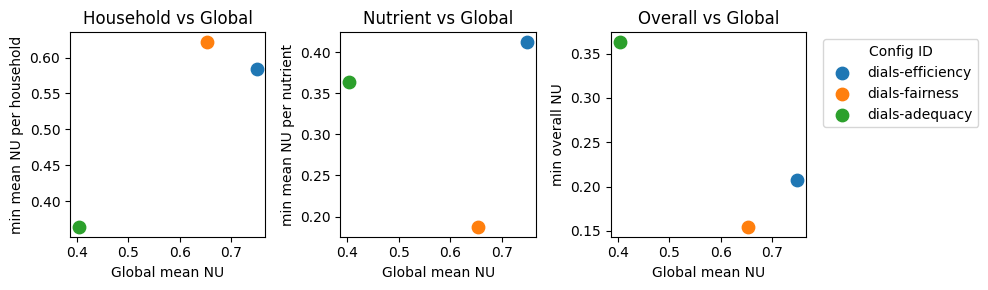

In [ ]:
# Plot global vs minima KPIs (mean nutritional utilities)

def plot_global_vs_minima(df: pd.DataFrame) -> None:
    label_map = {
        "Global mean nutritional utility": "Global mean NU",
        "Min mean nutritional utility per household": "min mean NU per household",
        "Min mean nutritional utility per nutrient": "min mean NU per nutrient",
        "Min overall nutritional utility": "min overall NU",
    }
    label_map_title = {
        "Global mean nutritional utility": "Global",
        "Min mean nutritional utility per household": "Household",
        "Min mean nutritional utility per nutrient": "Nutrient",
        "Min overall nutritional utility": "Overall",
    }

    required_index = list(label_map.keys())
    missing = [k for k in required_index if k not in df.index]
    if missing:
        raise KeyError(f"Missing KPI rows in dataframe: {missing}")
    config_labels = {
        "E": "dials-efficiency",
        "B": "dials-balanced",
        "F": "dials-fairness",
        "A": "dials-adequacy",
        "FA": "dials-fairness-adequacy",
    }
    scenarios = df.columns.tolist()
    colors = plt.cm.tab10(range(len(scenarios)))  # consistent palette for config IDs
    x_values = df.loc["Global mean nutritional utility"]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)
    targets = [
        "Min mean nutritional utility per household", #"min mean NU per household",
        "Min mean nutritional utility per nutrient", #"Min mean NU per nutrient",
        "Min overall nutritional utility", #"Min overall NU",
    ]
    for ax, target in zip(axes, targets):
        y_values = df.loc[target]
        for scenario, color in zip(scenarios, colors):
            ax.scatter(
                x_values[scenario],
                y_values[scenario],
                color=color,
                s=80,
                label=config_labels.get(scenario, scenario),
            )
        ax.set_xlabel(label_map["Global mean nutritional utility"])
        ax.set_ylabel(label_map[target])
        ax.set_title(f"{label_map_title[target]} vs Global")
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[2].legend(
        by_label.values(),
        by_label.keys(),
        title="Config ID",
        bbox_to_anchor=(1.05, 1), #(1.02, 1)
        loc="upper left",
    )
    fig.tight_layout()
    plt.show()

plot_global_vs_minima(df)

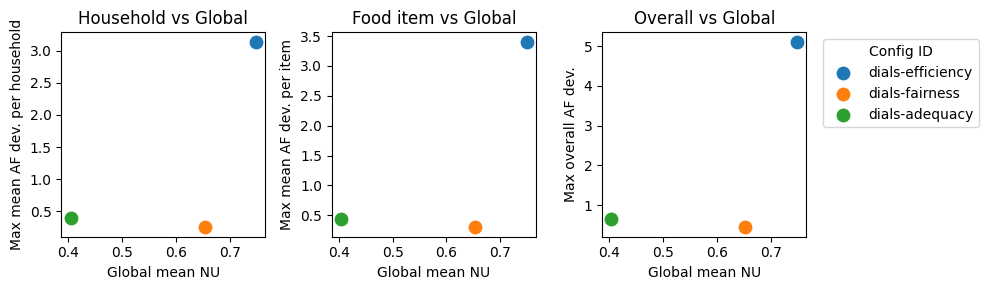

In [9]:
# Plot allocation fairness KPIs (mean absolute fair share deviations)

def plot_allocation_fairness(df: pd.DataFrame) -> None:
    label_map = {
        "Global mean nutritional utility": "Global mean NU",
        "Max mean deviation from fair share per household": "Max mean AF dev. per household",
        "Max mean deviation from fair share per food item": "Max mean AF dev. per item",
        "Max overall deviation from fair share": "Max overall AF dev.",
    }
    label_map_title = {
        "Global mean nutritional utility": "Global",
        "Max mean deviation from fair share per household": "Household",
        "Max mean deviation from fair share per food item": "Food item",
        "Max overall deviation from fair share": "Overall",
    }
    required_index = list(label_map.keys())
    missing = [metric for metric in required_index if metric not in df.index]
    if missing:
        raise KeyError(f"Missing allocation fairness KPI rows in dataframe: {missing}")
    config_labels = {
        "E": "dials-efficiency",
        "B": "dials-balanced",
        "F": "dials-fairness",
        "A": "dials-adequacy",
        "FA": "dials-fairness-adequacy",
    }
    scenarios = df.columns.tolist()
    colors = plt.cm.tab10(range(len(scenarios)))
    x_values = df.loc["Global mean nutritional utility"]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)
    targets = [
        "Max mean deviation from fair share per household",
        "Max mean deviation from fair share per food item",
        "Max overall deviation from fair share",
    ]
    for ax, target in zip(axes, targets):
        y_values = df.loc[target]
        for scenario, color in zip(scenarios, colors):
            ax.scatter(
                x_values[scenario],
                y_values[scenario],
                color=color,
                s=80,
                label=config_labels.get(scenario, scenario),
            )
        ax.set_xlabel(label_map["Global mean nutritional utility"])
        ax.set_ylabel(label_map[target])
        ax.set_title(f"{label_map_title[target]} vs Global")
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[2].legend(
        by_label.values(),
        by_label.keys(),
        title="Config ID",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    fig.tight_layout()
    plt.show()

plot_allocation_fairness(df)

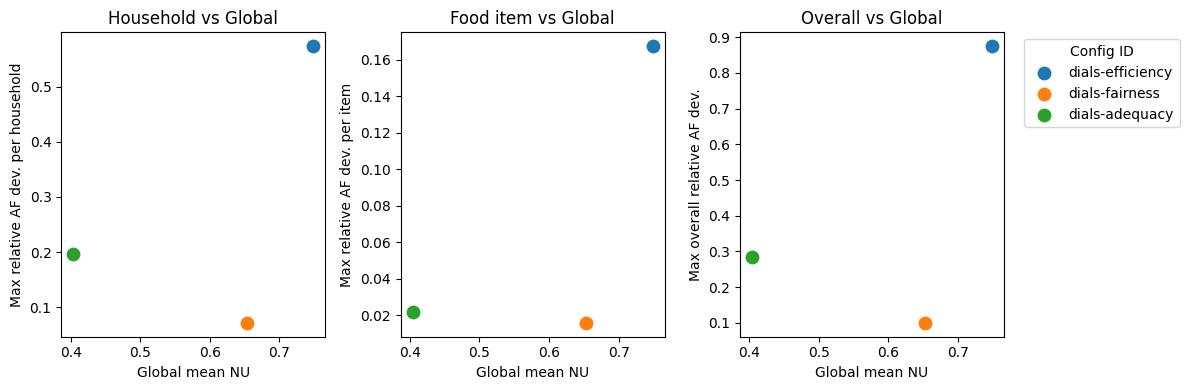

In [11]:
# Plot allocation fairness KPIs (relative deviations from fair share)

'''
- id: fairness.max_relative_deviation_from_fair_share_per_household
    label: Max relative deviation from fair share per household
- id: fairness.max_relative_deviation_from_fair_share_per_food_item
    label: Max relative deviation from fair share per food item
- id: fairness.max_relative_deviation_from_fair_share_per_pair
    label: Max overall relative deviation from fair share
'''


def plot_allocation_fairness(df: pd.DataFrame) -> None:
    label_map = {
        "Global mean nutritional utility": "Global mean NU",
        "Max relative deviation from fair share per household": "Max relative AF dev. per household",
        "Max relative deviation from fair share per food item": "Max relative AF dev. per item",
        "Max overall relative deviation from fair share": "Max overall relative AF dev.",
    }
    label_map_title = {
        "Global mean nutritional utility": "Global",
        "Max relative deviation from fair share per household": "Household",
        "Max relative deviation from fair share per food item": "Food item",
        "Max overall relative deviation from fair share": "Overall",
    }
    required_index = list(label_map.keys())
    missing = [metric for metric in required_index if metric not in df.index]
    if missing:
        raise KeyError(f"Missing allocation fairness KPI rows in dataframe: {missing}")
    config_labels = {
        "E": "dials-efficiency",
        "B": "dials-balanced",
        "F": "dials-fairness",
        "A": "dials-adequacy",
        "FA": "dials-fairness-adequacy",
    }
    scenarios = df.columns.tolist()
    colors = plt.cm.tab10(range(len(scenarios)))
    x_values = df.loc["Global mean nutritional utility"]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)
    targets = [
        "Max relative deviation from fair share per household",
        "Max relative deviation from fair share per food item",
        "Max overall relative deviation from fair share",
    ]
    for ax, target in zip(axes, targets):
        y_values = df.loc[target]
        for scenario, color in zip(scenarios, colors):
            ax.scatter(
                x_values[scenario],
                y_values[scenario],
                color=color,
                s=80,
                label=config_labels.get(scenario, scenario),
            )
        ax.set_xlabel(label_map["Global mean nutritional utility"])
        ax.set_ylabel(label_map[target])
        ax.set_title(f"{label_map_title[target]} vs Global")
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[2].legend(
        by_label.values(),
        by_label.keys(),
        title="Config ID",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    fig.tight_layout()
    plt.show()

plot_allocation_fairness(df)